In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf

# Data cleaning and normalization

In [2]:
training_session_folder = 'C:/Users/chiny/cjwen/ITI110/hourly_training'
df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")


In [3]:
df.isnull().sum()      

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

In [4]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])
# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]

,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


In [5]:
df = df.drop([15758, 15759])

In [6]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())


# Create X new columns using past X timestamp data

In [7]:
dataframe = df.loc[:,"avg_energy_per_lclid"]
dataset = dataframe.values
dataset = dataset.astype("float32")

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
history = 1
future = 1
reframed = series_to_supervised(dataset, history,future)
reframed.head(3)



,var1(t-1),var1(t)
1,0.565000,0.251333
2,0.251333,0.303286
3,0.303286,0.658900


In [14]:
scaler_label = MinMaxScaler(feature_range=(0, 1))

In [15]:
# Merge the reframed columns with weather and time features

In [16]:
reframed["month"] = df.month.values[history:]
reframed["hour"] = df.hour.values[history:]
reframed["temperature"] = df.temperature.values[history:]
reframed["humidity"] = df.humidity.values[history:]
reframed["windSpeed"] = df.windSpeed.values[history:]
reframed["holiday"] = df.holiday.values[history:]

In [17]:
reframed_tstp = pd.DataFrame()
reframed_tstp["tstp"] = df.tstp.values[history:]

In [18]:
reframed_tstp

,tstp
0,2011-11-23 10:00:00
1,2011-11-23 11:00:00
2,2011-11-23 12:00:00
3,2011-11-23 13:00:00
4,2011-11-23 14:00:00
...,...
19856,2014-02-27 20:00:00
19857,2014-02-27 21:00:00
19858,2014-02-27 22:00:00
19859,2014-02-27 23:00:00


In [19]:
reframed

,var1(t-1),var1(t),month,hour,temperature,humidity,windSpeed,holiday
1,0.565000,0.251333,11,10,5.74,0.98,1.99,0.0
2,0.251333,0.303286,11,11,7.67,0.88,2.66,0.0
3,0.303286,0.658900,11,12,8.84,0.85,2.80,0.0
4,0.658900,0.481769,11,13,9.87,0.82,3.12,0.0
5,0.481769,0.475692,11,14,10.36,0.84,3.26,0.0
...,...,...,...,...,...,...,...,...
19857,0.722878,0.694360,2,20,5.94,0.76,3.25,0.0
19858,0.694360,0.657011,2,21,5.03,0.79,3.06,0.0
19859,0.657011,0.587121,2,22,4.10,0.84,3.02,0.0
19860,0.587121,0.469473,2,23,3.93,0.85,2.75,0.0


In [20]:
reframed = reframed.reindex(["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-1)', 'var1(t)'],axis=1)

In [21]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19861 entries, 1 to 19861
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        19861 non-null  int64  
 1   hour         19861 non-null  int64  
 2   temperature  19861 non-null  float64
 3   humidity     19861 non-null  float64
 4   windSpeed    19861 non-null  float64
 5   holiday      19861 non-null  float64
 6   var1(t-1)    19861 non-null  float32
 7   var1(t)      19861 non-null  float32
dtypes: float32(2), float64(4), int64(2)
memory usage: 1.2 MB


In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))

reframed[["month","hour","temperature","humidity","windSpeed","holiday"]] = scaler.fit_transform(reframed[["month","hour","temperature","humidity","windSpeed","holiday"]])

In [24]:
# !pip install joblib

In [27]:
#Export scaler
from joblib import dump

scaler_path = 'deployment/scaler.joblib'

dump(scaler,scaler_path)

print(f"Scaler saved to {scaler_path}")

Scaler saved to deployment/scaler.joblib


In [28]:
train_rows = int(0.8*len(reframed))
train = reframed[:train_rows]
test = reframed[train_rows:]

print("dataset no. of rows: ", len(reframed))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

dataset no. of rows:  19861
train dataset no. of rows:  15888
test dataset no. of rows:  3973


In [29]:
train_tstp = reframed_tstp[:train_rows]
test_tstp = reframed_tstp[train_rows:]

print("dataset no. of rows: ", len(reframed_tstp))
print("train_tstp dataset no. of rows: ", len(train_tstp))
print("test_tstp dataset no. of rows: ", len(test_tstp))

dataset no. of rows:  19861
train_tstp dataset no. of rows:  15888
test_tstp dataset no. of rows:  3973


In [30]:
test.tail()

,month,hour,temperature,humidity,windSpeed,holiday,var1(t-1),var1(t)
19857,0.090909,0.869565,0.304416,0.688312,0.217480,0.0,0.722878,0.694360
19858,0.090909,0.913043,0.280494,0.727273,0.204607,0.0,0.694360,0.657011
19859,0.090909,0.956522,0.256046,0.792208,0.201897,0.0,0.657011,0.587121
19860,0.090909,1.000000,0.251577,0.805195,0.183604,0.0,0.587121,0.469473
19861,0.090909,0.000000,0.248423,0.805195,0.168699,0.0,0.469473,0.209844


In [31]:
features = ["month", "hour", "temperature","humidity","windSpeed","holiday","var1(t-1)"]
label = ["var1(t)"]

In [33]:
x_train = np.array(train[features])
y_train = np.array(train[label])
x_test = np.array(test[features])
y_test = np.array(test[label])

In [35]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 

(15888, 1, 7) (15888, 1) (3973, 1, 7) (3973, 1)


In [36]:
def performance_visualization(model, train_input, train_actual, test_input, test_actual, start_row=0, end_row=100):
    train_result = pd.DataFrame()
    train_pred = model.predict(train_input)
    train_mae = mae(train_actual, train_pred)
    train_mape = mape(train_actual,train_pred)
    train_rmse = math.sqrt(mean_squared_error(train_actual,train_pred))
    train_result["tstp"] = train_tstp["tstp"]
    train_result["tstp"] = pd.to_datetime(train_result["tstp"])
    train_result["train_pred"]= train_pred
    train_result["train_actual"]= train_actual
    print(f"Train MAE: {train_mae}")
    print(f"Train MAPE: {train_mape}")
    print(f"Train RMSE: {train_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "train_actual", label='actual', data = train_result[start_row:end_row])
    plt.plot("tstp", "train_pred", label='prediction', data = train_result[start_row:end_row])

    # plt.plot(train_pred[start_row:end_row], label='prediction', x = "tstp")
    plt.title("Train Actual vs prediction")
    plt.legend()
    plt.show()
              
              
    test_result = pd.DataFrame()
    test_pred = model.predict(test_input)
    test_mae = mae(test_actual, test_pred)
    test_mape = mape(test_actual,test_pred)
    test_rmse = math.sqrt(mean_squared_error(test_actual,test_pred))
    test_result["tstp"] = test_tstp["tstp"]
    test_result["tstp"] = pd.to_datetime(test_result["tstp"])
    test_result["test_pred"]= test_pred
    test_result["test_actual"]= test_actual
    print(f"Test MAE: {test_mae}")
    print(f"Test MAPE: {test_mape}")
    print(f"Test RMSE: {test_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "test_actual", label='actual', data = test_result[start_row:end_row])
    plt.plot("tstp", "test_pred", label='prediction', data = test_result[start_row:end_row])
    plt.title("Test Actual vs prediction")
    plt.legend()
    plt.show()          
    
    return train_result, test_result

# Run 17 - 2 layers LSTM 96 neurons

In [46]:
model17 = Sequential()
    
model17.add(LSTM(units = 96, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model17.add(LSTM(units = 96))
model17.add(Dense(1))
    
model17.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanAbsoluteError()])

In [47]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_17/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

Epoch 1/500
497/497 [==============================] - 4s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.0599 - val_loss: 0.0415 - val_mean_absolute_error: 0.0415
Epoch 2/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0374 - mean_absolute_error: 0.0374 - val_loss: 0.0400 - val_mean_absolute_error: 0.0400
Epoch 3/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381
Epoch 4/500
497/497 [==============================] - 2s 3ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0349 - val_mean_absolute_error: 0.0349
Epoch 5/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0341 - mean_absolute_error: 0.0341 - val_loss: 0.0342 - val_mean_absolute_error: 0.0342
Epoch 6/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0332 - mean_absolute_error: 0.0332 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 7/50

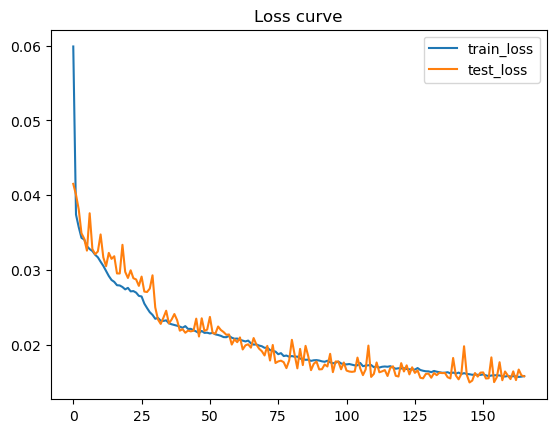

In [48]:
history = model17.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

497/497 [==============================] - 1s 1ms/step
Train MAE: 0.015364117920398712
Train MAPE: 0.035238850861787796
Train RMSE: 0.022543054756849222


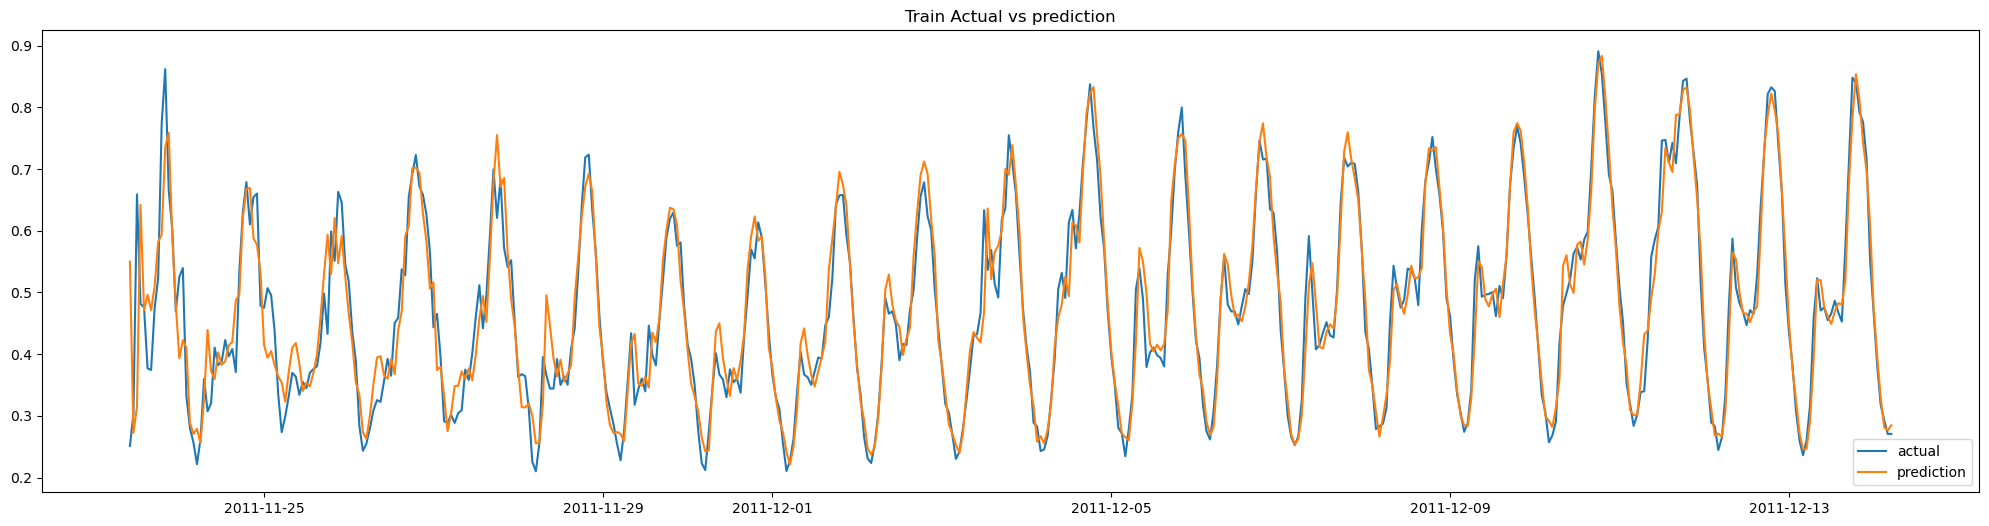

125/125 [==============================] - 0s 1ms/step
Test MAE: 0.015766534954309464
Test MAPE: 0.03627140074968338
Test RMSE: 0.021258032948946667


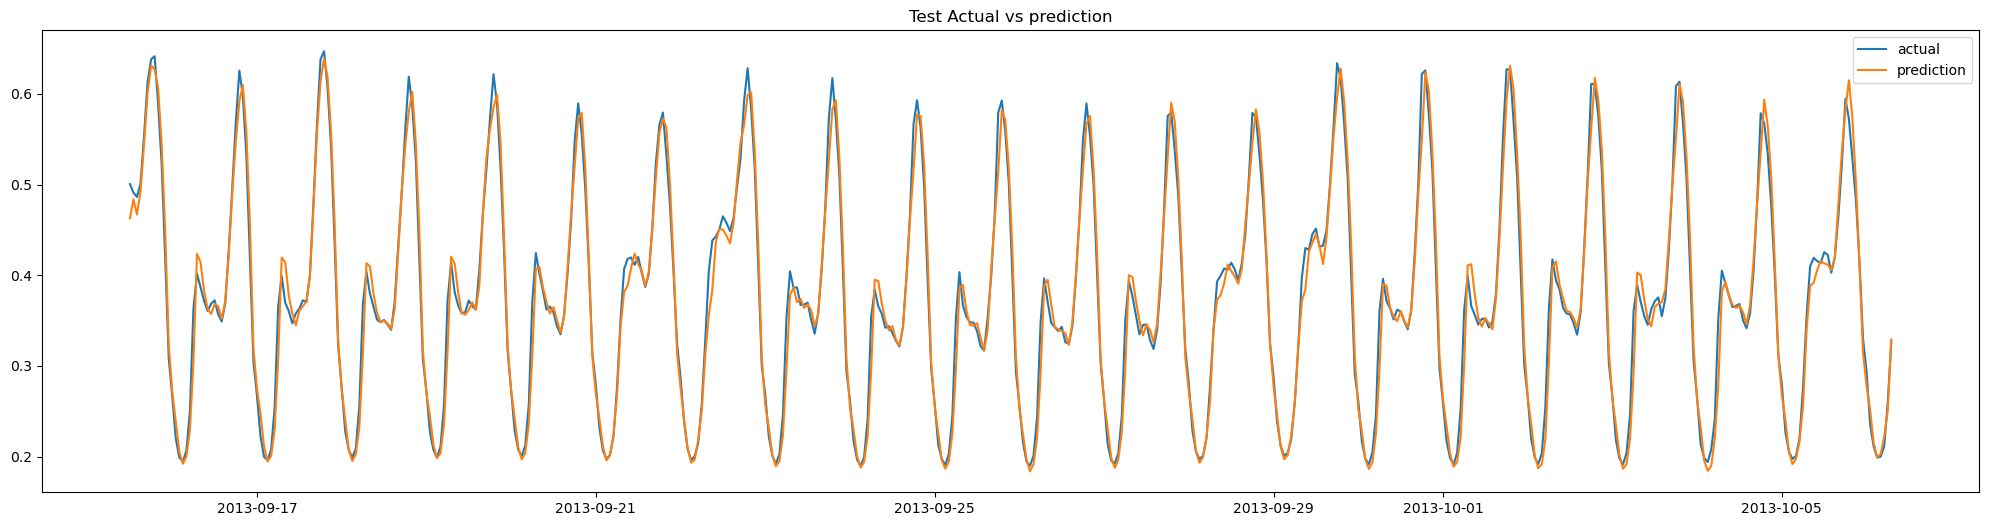

In [53]:
train_result, test_result = performance_visualization(model17, x_train, y_train, x_test, y_test, 0, 500)

In [54]:
test_result["delta"] = abs(test_result["test_pred"] - test_result["test_actual"])
test_result["percentage_delta"] = (abs(test_result["test_pred"] - test_result["test_actual"]))/abs(test_result["test_actual"])
test_result["hour"] = test_result["tstp"].dt.hour.astype('str')
test_result["month"] = test_result["tstp"].dt.month.astype('str')
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3973 entries, 15888 to 19860
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tstp              3973 non-null   datetime64[ns]
 1   test_pred         3973 non-null   float32       
 2   test_actual       3973 non-null   float32       
 3   delta             3973 non-null   float32       
 4   percentage_delta  3973 non-null   float32       
 5   hour              3973 non-null   object        
 6   month             3973 non-null   object        
dtypes: datetime64[ns](1), float32(4), object(2)
memory usage: 155.3+ KB


In [55]:
import seaborn as sns

In [56]:
# plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
# ax = sns.catplot(data=test_result, y = "delta", hue = "hour", alpha=.3, marker="D")

In [57]:
# plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
# sns.displot(test_result, x="delta", hue = "hour")

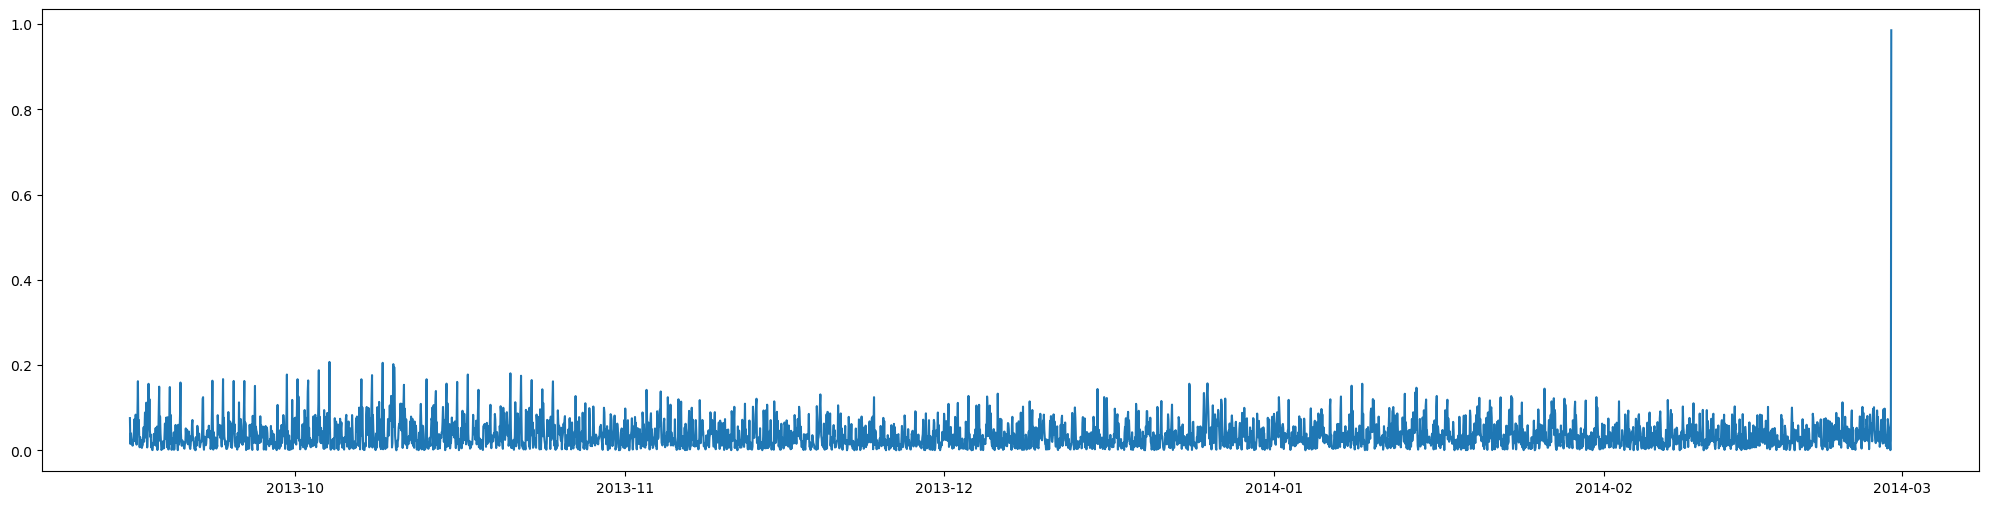

In [58]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot("tstp", "percentage_delta", data=test_result)

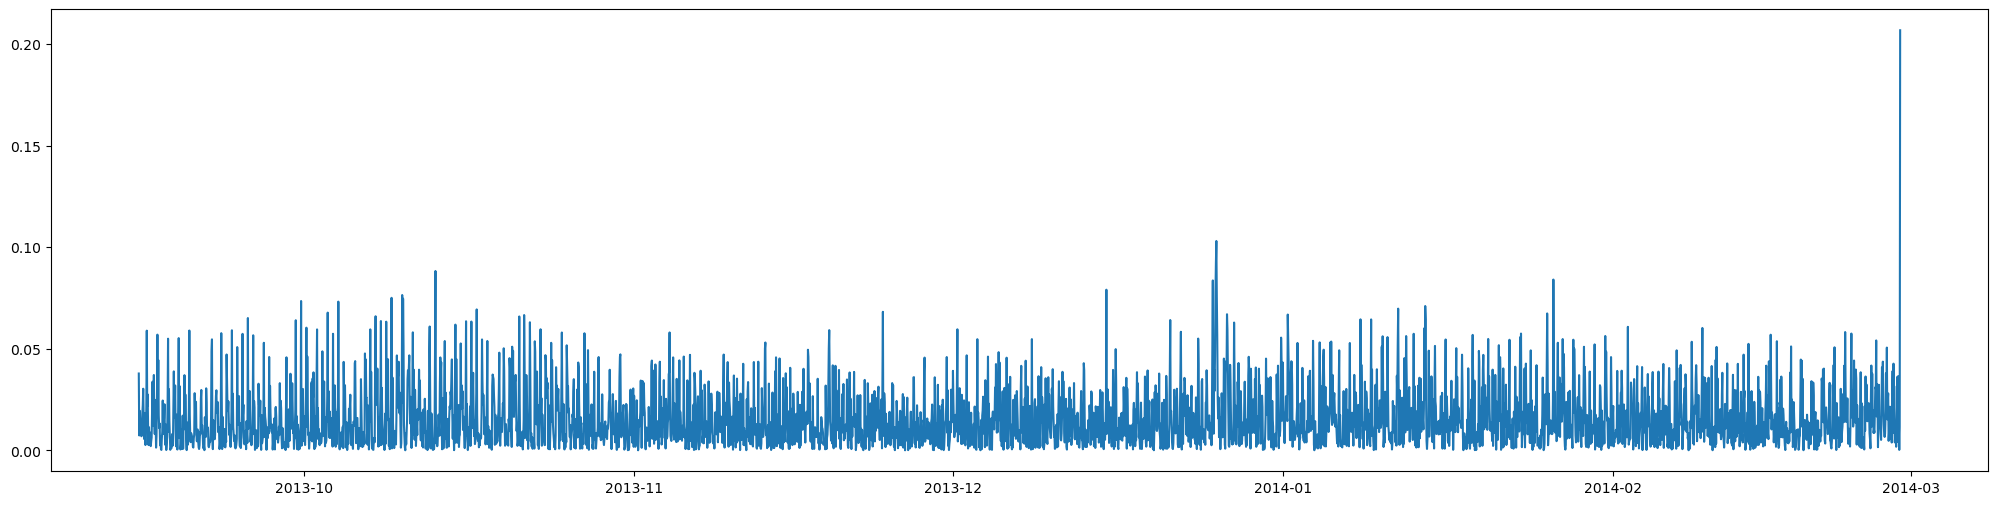

In [59]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot("tstp", "delta", data=test_result)

In [60]:
delta_by_hour = pd.DataFrame()
delta_by_hour = test_result["delta"].groupby(test_result["hour"]).describe()
delta_by_hour.sort_values(by="50%")

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
3,165.0,0.005523,0.005189,2.622604e-05,0.002035,0.004219,0.007354,0.025705
4,165.0,0.007029,0.004622,1.242608e-04,0.003416,0.006558,0.009893,0.023979
12,166.0,0.008467,0.007943,5.960464e-08,0.003172,0.006581,0.011215,0.055941
13,166.0,0.009698,0.010026,1.400709e-05,0.002472,0.006617,0.011710,0.053530
14,166.0,0.009184,0.008721,2.145767e-05,0.002988,0.007398,0.013347,0.056242
22,166.0,0.011981,0.011747,4.017353e-05,0.003120,0.007782,0.015785,0.046739
11,165.0,0.011416,0.011821,4.431605e-05,0.003375,0.008110,0.013913,0.066833
5,165.0,0.010724,0.008859,6.395578e-05,0.003598,0.008231,0.016612,0.035084
15,166.0,0.011168,0.008875,1.135767e-04,0.004616,0.009267,0.016037,0.047660


In [62]:
stat_styled=delta_by_hour.drop(columns = "count", axis=1).style.background_gradient()
stat_styled

,mean,std,min,25%,50%,75%,max
hour,,,,,,,
0,0.013727,0.018314,0.000092,0.004654,0.010267,0.017863,0.206832
1,0.019565,0.009703,0.000075,0.013414,0.018496,0.026218,0.055004
10,0.020031,0.018641,0.000004,0.007029,0.013124,0.027597,0.084069
11,0.011416,0.011821,0.000044,0.003375,0.008110,0.013913,0.066833
12,0.008467,0.007943,0.000000,0.003172,0.006581,0.011215,0.055941
13,0.009698,0.010026,0.000014,0.002472,0.006617,0.011710,0.053530
14,0.009184,0.008721,0.000021,0.002988,0.007398,0.013347,0.056242
15,0.011168,0.008875,0.000114,0.004616,0.009267,0.016037,0.047660
16,0.014686,0.012737,0.000063,0.005260,0.011041,0.020372,0.077720


In [63]:
percentage_delta_by_hour = pd.DataFrame()
percentage_delta_by_hour = test_result["percentage_delta"].groupby(test_result["hour"]).describe()
percentage_delta_by_hour.sort_values(by="50%")

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
22,166.0,0.025040,0.028674,6.845882e-05,0.005239,0.013130,0.029154,0.113514
12,166.0,0.017892,0.014906,1.376211e-07,0.007418,0.014965,0.025316,0.094080
13,166.0,0.020034,0.017646,3.841263e-05,0.005113,0.015904,0.029912,0.084357
14,166.0,0.019639,0.016551,4.681456e-05,0.007054,0.016133,0.029697,0.099769
3,165.0,0.022987,0.020528,1.008576e-04,0.008568,0.019046,0.031138,0.103143
11,165.0,0.024243,0.022347,1.047418e-04,0.008804,0.019308,0.032626,0.124743
19,166.0,0.025898,0.020676,9.569239e-05,0.011275,0.020360,0.036412,0.117555
15,166.0,0.024071,0.017780,2.249707e-04,0.009664,0.020981,0.036151,0.085779
16,166.0,0.028702,0.025018,1.396373e-04,0.010264,0.022213,0.040380,0.117717


In [64]:
percentage_delta_styled=percentage_delta_by_hour.drop(columns = "count", axis=1).style.background_gradient()
percentage_delta_styled

,mean,std,min,25%,50%,75%,max
hour,,,,,,,
0,0.037239,0.077837,0.000282,0.011904,0.028844,0.043894,0.985645
1,0.065255,0.030918,0.000217,0.044204,0.064407,0.084161,0.156161
10,0.041693,0.034525,0.000009,0.017554,0.030406,0.058758,0.144811
11,0.024243,0.022347,0.000105,0.008804,0.019308,0.032626,0.124743
12,0.017892,0.014906,0.000000,0.007418,0.014965,0.025316,0.094080
13,0.020034,0.017646,0.000038,0.005113,0.015904,0.029912,0.084357
14,0.019639,0.016551,0.000047,0.007054,0.016133,0.029697,0.099769
15,0.024071,0.017780,0.000225,0.009664,0.020981,0.036151,0.085779
16,0.028702,0.025018,0.000140,0.010264,0.022213,0.040380,0.117717


# Run 15 - 2 layers LSTM with keras tuner

In [75]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_2))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [76]:
tuner15=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [36]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_15/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [37]:
tuner15.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters


Trial 90 Complete [00h 01m 55s]
val_mean_absolute_error: 0.019701773300766945

Best val_mean_absolute_error So Far: 0.013977906666696072
Total elapsed time: 02h 57m 20s


In [40]:
best_hps=tuner15.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')}, second LSTM layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 480, second LSTM layer is 480 and the optimal learning rate for the optimizer
is 0.01.



In [ ]:
model = Sequential()

model.add(LSTM(units = 480, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units = 480))
model.add(Dense(1))
model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.01y), metrics=[keras.metrics.MeanAbsoluteError()])

# Run 16 3 layers LSTM with keras tuner

In [77]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_2, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_3))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [79]:
# current_folder_name = "untitled_project"
# new_folder_name = "Run_15_kerastuner"
# if os.path.exists(current_folder_name): 
#     os.rename(current_folder_name, new_folder_name)
#     print(f"Folder renamed from {current_folder_name} to {new_folder_name}")
# else:
#     print(f"The folder '{current_folder_name}' does not exist.")

In [80]:
tuner16=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 100, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [81]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_16/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [ ]:
tuner16.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters


Trial 250 Complete [00h 06m 28s]
val_mean_absolute_error: 0.018505452200770378

Best val_mean_absolute_error So Far: 0.011782856658101082
Total elapsed time: 03h 45m 07s

Search: Running Trial #251

Value             |Best Value So Far |Hyperparameter
96                |224               |units
480               |32                |units_2
448               |128               |units_3
0.0001            |0.01              |learning_rate
100               |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
0                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/100
497/497 [==============================] - 11s 14ms/step - loss: 0.1044 - mean_absolute_error: 0.1044 - val_loss: 0.0522 - val_mean_absolute_error: 0.0522
Epoch 2/100
497/497 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411
Epoch 3/100
497

In [ ]:
best_hps=tuner16.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')}, second LSTM layer is {best_hps.get('units_2')}, third LSTM layer is {best_hps.get('units_3')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")